In [1]:
import os
import sys
import traci
from sumolib import checkBinary 

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

# variable
useGui = False
numCars = 5000
net_file = './saint_paul/junction.net.xml'
route_path = f'./saint_paul/1.0hour/trips/{numCars}.rou.xml'

if(useGui): sumoBinary = checkBinary('sumo-gui')
else: sumoBinary = checkBinary('sumo')
sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path,
           "--quit-on-end", "--waiting-time-memory", '10000',
           '--time-to-teleport', '-1', '--start']

traci.start(sumoCmd)

trafficLightId = traci.trafficlight.getIDList()[0]
allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases

swithTime = 10
currentPhase = 0
yellowPhase = True

def getAlllanes(edge):
  return [lane for lane in allLanes if edge in lane]

def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

north_lane = getAlllanes('E2')
south_lane = getAlllanes('E0')
east_lane = getAlllanes('E3')
west_lane = getAlllanes('E1')

car_north = set()
car = set()
car_time = {}

all_car_in_sim = []

while traci.simulation.getMinExpectedNumber() > 0:
  traci.simulationStep()

  """
  if vehPerHours = 3, car will come at 1s (0/3*3600 + 1), 1201s (1/3*3600 + 1) , 1801s(2/3*3600 + 1)
  if vehPerHours = 5, car will come at 1s (0/5*3600 + 1), 721s (1/5*3600 + 1) , 1441s(2/5*3600 + 1)
  """

  vehicles = traci.vehicle.getIDList()
  now_time = traci.simulation.getTime()
  car_time[now_time] = 0

  all_car_in_sim.append(len(vehicles))

  for vehicle in vehicles:
    if vehicle not in car:
      car.add(vehicle)
      car_time[now_time] += 1
  
traci.close()

 Retrying in 1 seconds


Step #5641.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 5008 ACT 0 BUF 0)                 


In [154]:
total_cars = 0
for car in car_time:
  total_cars += car_time[car]
total_cars

5008

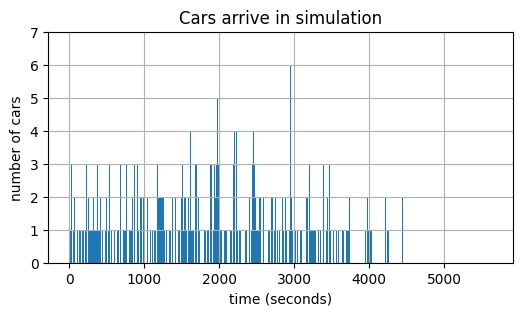

In [4]:
import matplotlib.pyplot as plt
import numpy as np

time = list(car_time.keys())
number_of_cars = list(car_time.values())

plt.subplots(figsize=(6, 3))
plt.bar(time[::], number_of_cars[::])
plt.title('Cars arrive in simulation')
plt.ylim(0, 7)
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()

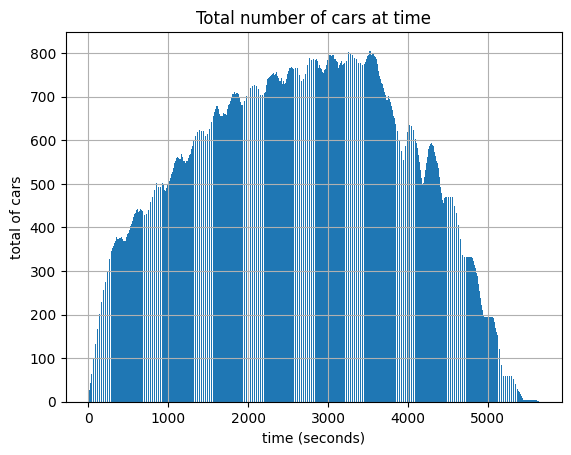

In [170]:
#plt.subplots(figsize=(10, 3))
plt.bar(np.arange(len(all_car_in_sim)), all_car_in_sim)
plt.title('Total number of cars at time')
plt.xlabel('time (seconds)')
plt.ylabel('total of cars')
plt.grid()
plt.show()

# Theory

In [157]:
import xml.etree.ElementTree as ET

tree = ET.parse('./saint_paul/1.0hour/trips/5000.rou.xml')
root = tree.getroot()
flows = root.findall('flow')
num_of_cars_flow = {}
num_cars = {}

for flow in flows:
    vph = int(flow.get('vehsPerHour'))
    for i in range(vph):
        depart_time = i/vph*3600 + 1 
        if depart_time not in num_cars: num_cars[depart_time] = 1
        else: num_cars[depart_time] += 1

    num_of_cars_flow[flow.get('id')] = [int(i/vph*3600) + 1 for i in range(vph)]


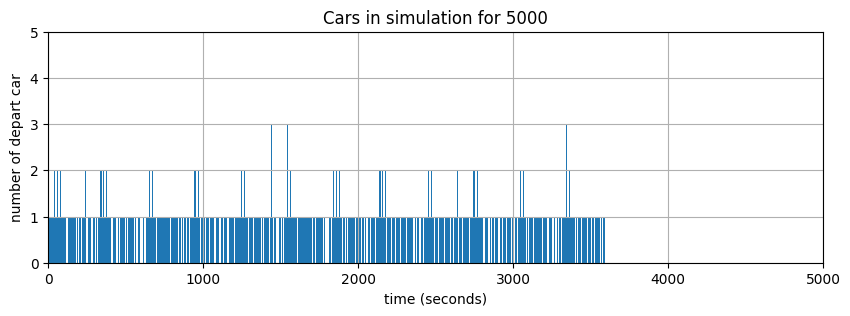

In [178]:
plt.subplots(figsize=(10, 3))
plt.bar(list(num_cars.keys()), list(num_cars.values()), width=1)
plt.xlabel('time (seconds)')
plt.ylim(0, 5)
plt.xlim(0, 5000)
plt.ylabel('number of arrive car')
plt.title('Cars in simulation for 5000')
plt.grid()
plt.show()